# Online Payments Fraud Detection
## Machine Learning in Finance - Final Project

### 1. Project Overview
**Objective:** The goal of this project is to build a machine learning model to detect fraudulent online payment transactions.  
**Problem Type:** Binary Classification (Fraud vs. Non-Fraud).  
**Dataset:** Kaggle "Online Payments Fraud Detection".

**Features:**
*   `step`: Unit of time (1 hour).
*   `type`: Type of online transaction.
*   `amount`: Transaction amount.
*   `nameOrig`: Customer starting the transaction.
*   `oldbalanceOrg`: Balance before transaction.
*   `newbalanceOrig`: Balance after transaction.
*   `nameDest`: Recipient of the transaction.
*   `oldbalanceDest`: Initial balance of recipient.
*   `newbalanceDest`: New balance of recipient.
*   `isFraud`: Target variable (1 = Fraud, 0 = Legitimate).
*   `isFlaggedFraud`: System flag (will be dropped to prevent leakage/bias).

### 2. Setup & Data Loading
We begin by importing necessary libraries and loading the dataset.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LearningCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, auc, PrecisionRecallDisplay, average_precision_score, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE

# Plotting settings
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Dataset
# Adjust the path if necessary
file_path = 'PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 3. Exploratory Data Analysis (EDA)
In this section, we analyze the data distribution, check for imbalances, and visualize correlations.



In [3]:
# Basic Info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


isFraud
0    6354407
1       8213
Name: count, dtype: int64


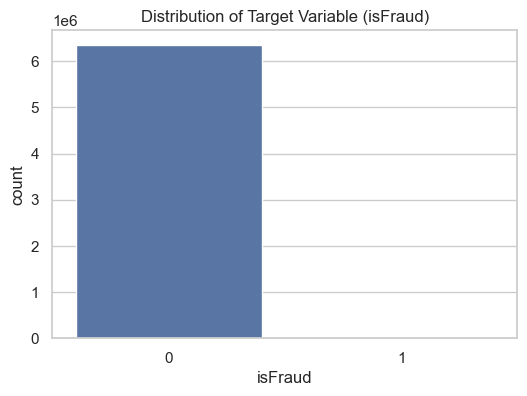

Fraud Ratio: 0.1291%


In [4]:
# Class Imbalance Analysis
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Target Variable (isFraud)')
plt.show()

print(f"Fraud Ratio: {df['isFraud'].mean():.4%}")


**Observation:** The dataset is highly imbalanced, with fraud cases occurring very rarely (~0.13%).

#### Transaction Type Analysis
Let's see which transaction types are associated with fraud.



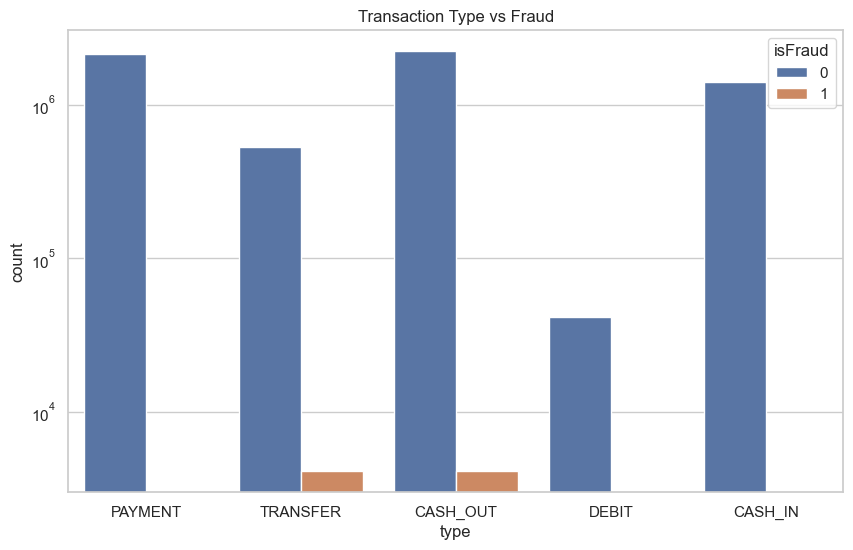

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Type vs Fraud')
plt.yscale('log') # Log scale because fraud count is small
plt.show()

# Precise counts
print(df.groupby('type')['isFraud'].sum())


**Key Insight:** Fraud *only* occurs in `TRANSFER` and `CASH_OUT` transactions. We can filter our dataset to focus only on these types, significantly reducing noise and data size.

#### Numerical Correlation



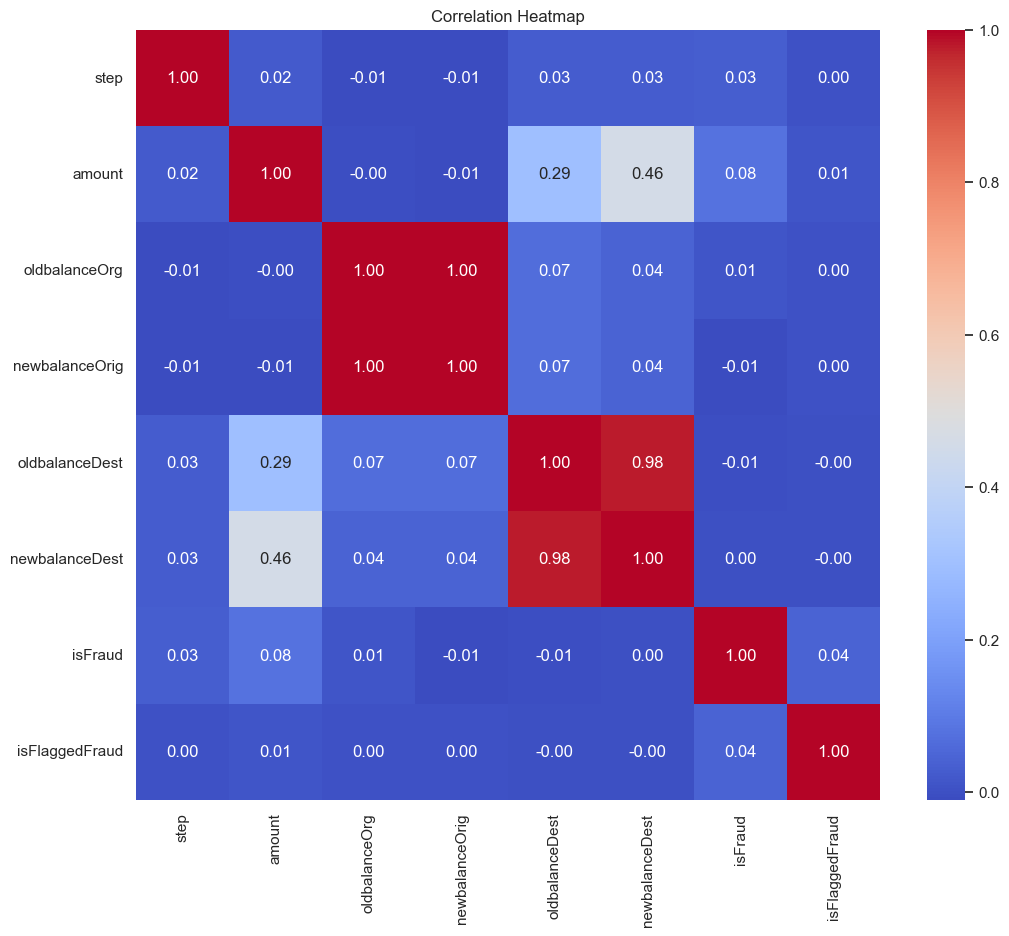

In [6]:
# Correlation Heatmap
# Filter numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


**Correlation Insights:** The heatmap demonstrates that **isFraud** has weak linear correlations with most features, implying that fraud patterns are complex and non-linear. However, strong multicollinearity exists between balance features (e.g., `oldbalanceOrg` and `newbalanceOrig`), which is expected given their nature.


#### Fraud Distribution Over Time (Step)
Since `step` represents time, we must verify if fraud is uniformly distributed or evolves over time. This informs our splitting strategy (Random vs Time-Series).



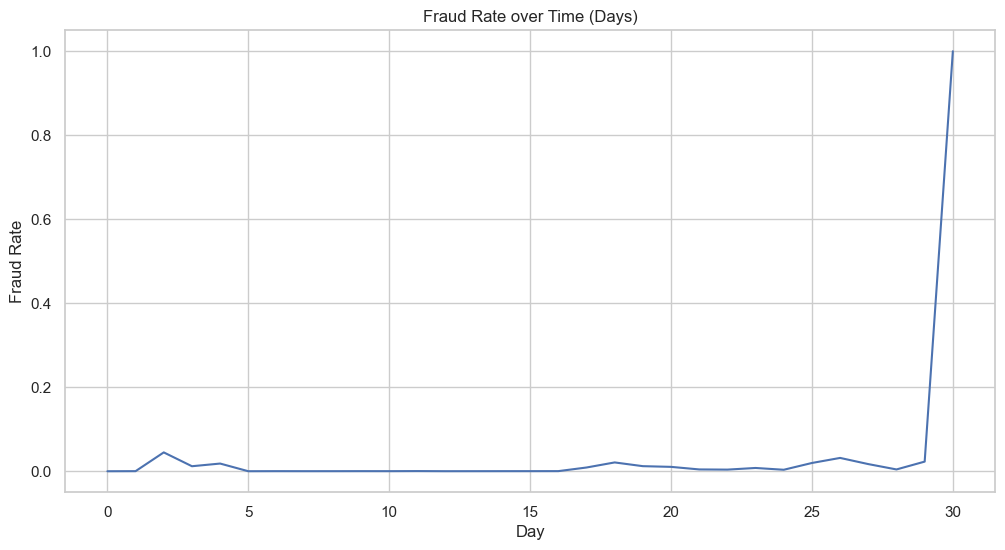

In [7]:
# Check fraud rate over time (grouped by day, assuming 1 step = 1 hour)
df['day'] = df['step'] // 24
fraud_over_time = df.groupby('day')['isFraud'].mean()

plt.figure(figsize=(12,6))
fraud_over_time.plot()
plt.title("Fraud Rate over Time (Days)")
plt.ylabel("Fraud Rate")
plt.xlabel("Day")
plt.show()


### 4. Data Preprocessing
Refining the dataset for modeling.

**Steps:**
1.  **Filtering:** Keep only `TRANSFER` and `CASH_OUT`.
2.  **Dropping Columns:** Remove IDs (`nameOrig`, `nameDest`), `isFlaggedFraud` (leakage), and auxiliary columns.
3.  **One-Hot Encoding:** Convert `type` column to binary indicators using One-Hot Encoding.
4.  **Time-Series Splitting:** Since `step` is time-based and fraud patterns may evolve, we will use a time-based split (First 80% for Train, Last 20% for Test) rather than random shuffling, to avoid leaking future information into the model.
5.  **Scaling:** Standard Scaling.



In [8]:
# 1. Filtering
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
print("Filtered Shape:", df_filtered.shape)

# 2. Drop Columns
df_filtered.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'day'], inplace=True, errors='ignore')

# 3. One-Hot Encoding
# We use one-hot encoding instead of label encoding as requested.
# drop_first=True avoids multicollinearity (dummy trap), effectively creating a single flag since we only have 2 types left.
df_encoded = pd.get_dummies(df_filtered, columns=['type'], prefix='type', drop_first=True)
print("Encoded Columns:", df_encoded.columns.tolist())
df_encoded.head()


Filtered Shape: (2770409, 12)
Encoded Columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_TRANSFER']


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,True
3,1,181.00,181.0,0.0,21182.0,0.00,1,False
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,False
19,1,215310.30,705.0,0.0,22425.0,0.00,0,True
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,True


#### Time-Series Split
We split the data by `step` to respect the temporal order.



In [9]:
# Sort by step just in case (though log data is usually ordered)
df_sorted = df_encoded.sort_values(by='step')

# 80/20 Time Split
split_index = int(len(df_sorted) * 0.8)

X = df_sorted.drop('isFraud', axis=1)
y = df_sorted['isFraud']

X_train_raw = X.iloc[:split_index]
X_test_raw = X.iloc[split_index:]
y_train_raw = y.iloc[:split_index]
y_test_raw = y.iloc[split_index:]

print(f"Train Set: {len(X_train_raw)} rows (Dates before step {X_train_raw['step'].max()})")
print(f"Test Set: {len(X_test_raw)} rows (Dates after step {X_test_raw['step'].min()})")

print("Train Fraud Rate:", y_train_raw.mean())
print("Test Fraud Rate:", y_test_raw.mean())


Train Set: 2216327 rows (Dates before step 354)
Test Set: 554082 rows (Dates after step 354)
Train Fraud Rate: 0.001783581574379593
Test Fraud Rate: 0.007688392692778326


#### Sampling Training Data (Undersampling)
The dataset is very large (~2M+ training rows). Algorithms like **KNN** are computationally expensive (O(N*M)) and will not run efficiently on millions of rows. **Logistic Regression** and **Random Forest** can handle it, but training will be slow.

To ensure efficient training and experimentation, we will create a balanced "working training set" by:
1.  Keeping **ALL** Fraud cases from the training period (to preserve minority class signal).
2.  Randomly undersampling Non-Fraud cases from the training period.

*Note: We apply this sampling ONLY to the Training set. The Test set remains untouched (except for scaling) to represent the real-world imbalanced scenario.*



In [10]:
# Separate Fraud and Non-Fraud in Training Set
# Combine X and y temporarily for easier sampling
train_data = pd.concat([X_train_raw, y_train_raw], axis=1)

train_fraud = train_data[train_data['isFraud'] == 1]
train_non_fraud = train_data[train_data['isFraud'] == 0]

print(f"Training Fraud Count: {len(train_fraud)}")
print(f"Training Non-Fraud Count: {len(train_non_fraud)}")

# Sample Non-Fraud to a manageable number (1,000,000)
# We use a large sample to maximize model performance (Logistic Regression benefits from more data).
SAMPLE_SIZE = 1000000
train_non_fraud_sampled = train_non_fraud.sample(n=SAMPLE_SIZE, random_state=42)

# Combine
train_sampled = pd.concat([train_fraud, train_non_fraud_sampled])
# Shuffle to mix classes (random_state for reproducibility)
train_sampled = train_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Sampled Training Shape:", train_sampled.shape)

X_train = train_sampled.drop('isFraud', axis=1)
y_train = train_sampled['isFraud']

# For Testing, we use the raw split (X_test_raw, y_test_raw)
# We use the FULL test set (no downsampling) to ensure a realistic evaluation.
test_data = pd.concat([X_test_raw, y_test_raw], axis=1)
test_sampled = test_data

X_test = test_sampled.drop('isFraud', axis=1)
y_test = test_sampled['isFraud']

print("Final Test Set (for Evaluation):", X_test.shape)


Training Fraud Count: 3953
Training Non-Fraud Count: 2212374
Sampled Training Shape: (1003953, 8)
Final Test Set (for Evaluation): (554082, 7)


#### Scaling
Standardizing features (Mean=0, Variance=1) is essential for convergence (LogReg) and distance calculations (KNN).



In [11]:
scaler = StandardScaler()

# Fit on Training Data ONLY
X_train_scaled = scaler.fit_transform(X_train)

# Transform Test Data using Training statistics
X_test_scaled = scaler.transform(X_test)


### 5. Handling Imbalance (SMOTE)
We use **SMOTE** (Synthetic Minority Over-sampling Technique) to balance the training set perfectly (50/50) by generating synthetic fraud examples. This helps models learn the decision boundary better.



In [12]:
print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: isFraud
0    1000000
1       3953
Name: count, dtype: int64
After SMOTE: isFraud
0    1000000
1    1000000
Name: count, dtype: int64


### 6. Model Implementation & Evaluation
We visualize the **Learning Curves** during training using the built-in `LearningCurveDisplay`.



In [13]:
# Helper Function for Learning Curves
def plot_learning_curve_graph(estimator, title, X, y, ylim=None, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig, ax = plt.subplots(figsize=(8, 6))
    LearningCurveDisplay.from_estimator(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1', ax=ax
    )
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.show()


#### 6.1 Logistic Regression
**Hyperparameters:**
*   `C=1.0`: Inverse of regularization strength. Smaller values specify stronger regularization.
*   `solver='lbfgs'`: Optimization algorithm. Good for datasets of this size.
*   `class_weight=None`: We rely on SMOTE for balancing, so we don't need to weight classes here.



Training Logistic Regression...


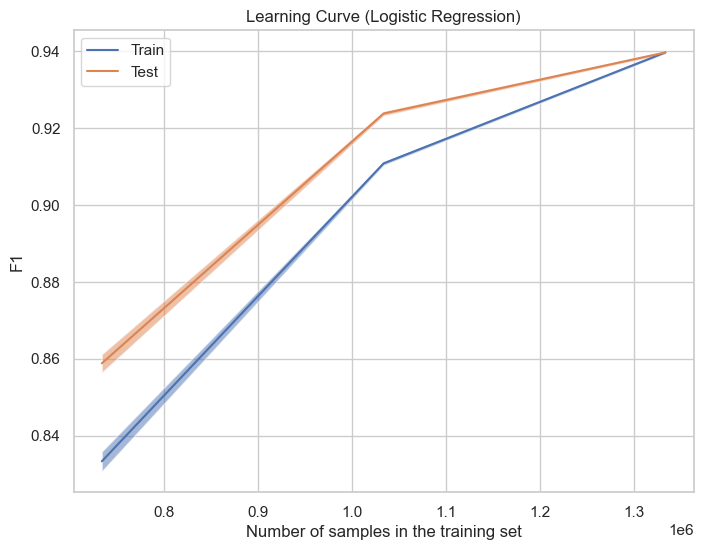

In [14]:
logreg = LogisticRegression(C=1.0, solver='lbfgs', random_state=42)

print("Training Logistic Regression...")
logreg.fit(X_train_smote, y_train_smote)

# Learning Curve
plot_learning_curve_graph(logreg, "Learning Curve (Logistic Regression)", X_train_smote, y_train_smote)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99    549822
           1       0.19      0.86      0.32      4260

    accuracy                           0.97    554082
   macro avg       0.60      0.91      0.65    554082
weighted avg       0.99      0.97      0.98    554082



<Figure size 600x500 with 0 Axes>

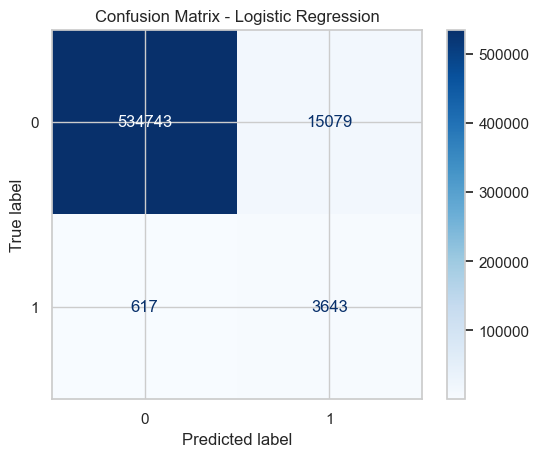

PR-AUC: 0.7169


In [15]:
# Evaluate
y_pred_logreg = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# PR-AUC
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
pr_auc_logreg = average_precision_score(y_test, y_prob_logreg)
print(f"PR-AUC: {pr_auc_logreg:.4f}")


#### 6.2 K-Nearest Neighbors (KNN)
**Hyperparameters:**
*   `n_neighbors=5`: The number of neighbors to predict the label.
*   `metric='minkowski'`: The distance metric (Euclidean distance when p=2). Standard for continuous numeric data.
*   `weights='uniform'`: All points in each neighborhood are weighted equally.



Training KNN...


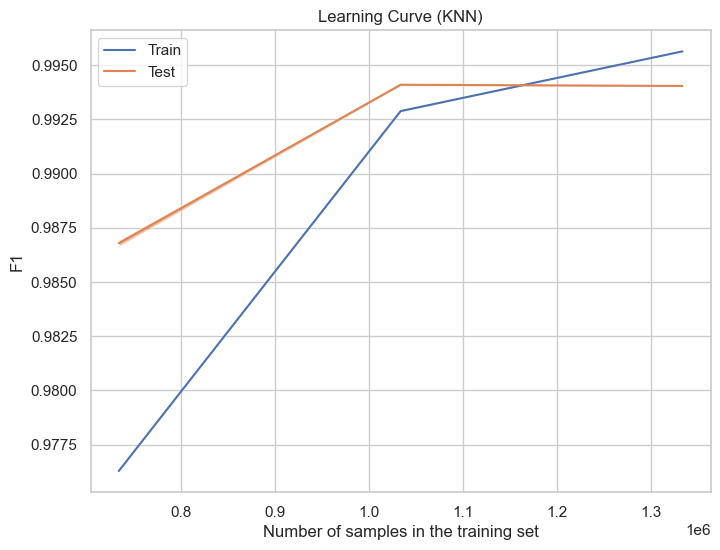

In [16]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', weights='uniform')

print("Training KNN...")
knn.fit(X_train_smote, y_train_smote)

plot_learning_curve_graph(knn, "Learning Curve (KNN)", X_train_smote, y_train_smote)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       0.71      0.63      0.67      4260

    accuracy                           1.00    554082
   macro avg       0.85      0.81      0.83    554082
weighted avg       0.99      1.00      1.00    554082



<Figure size 600x500 with 0 Axes>

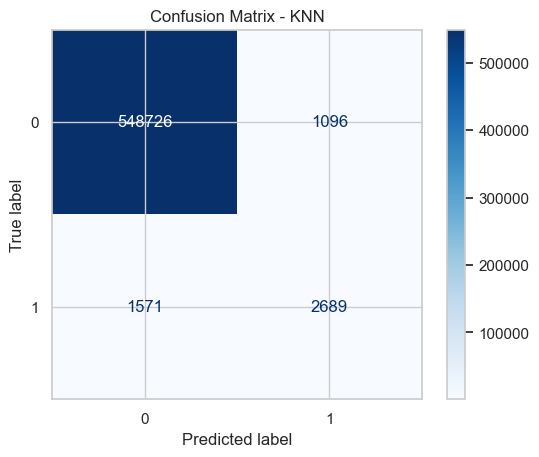

PR-AUC: 0.5749


In [17]:
# Evaluate
y_pred_knn = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.show()

# PR-AUC
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
pr_auc_knn = average_precision_score(y_test, y_prob_knn)
print(f"PR-AUC: {pr_auc_knn:.4f}")


#### 6.3 Random Forest Classifier
**Hyperparameters:**
*   `n_estimators=100`: The number of trees in the forest.
*   `max_depth= 5`: The maximum depth of the tree.
*   `random_state=42`: Ensures reproducibility.
*   `n_jobs=-1`: Uses all processors for faster training.
*   `min_samples_leaf=5`: The minimum number of samples required to be at a leaf node.



Training Random Forest...


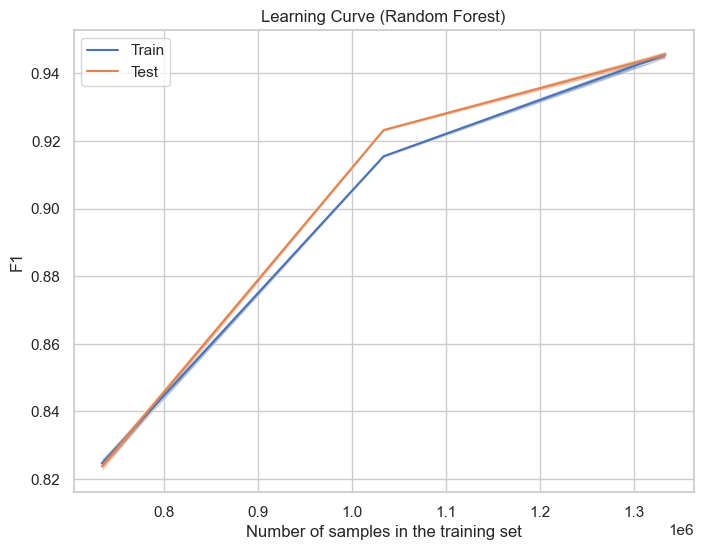

In [18]:
rf = RandomForestClassifier(n_estimators=100, max_depth= 5,
 random_state=42, n_jobs=-1, min_samples_leaf=5)

print("Training Random Forest...")
rf.fit(X_train_smote, y_train_smote)

plot_learning_curve_graph(rf, "Learning Curve (Random Forest)", X_train_smote, y_train_smote)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    549822
           1       0.17      0.92      0.29      4260

    accuracy                           0.97    554082
   macro avg       0.58      0.94      0.63    554082
weighted avg       0.99      0.97      0.98    554082



<Figure size 600x500 with 0 Axes>

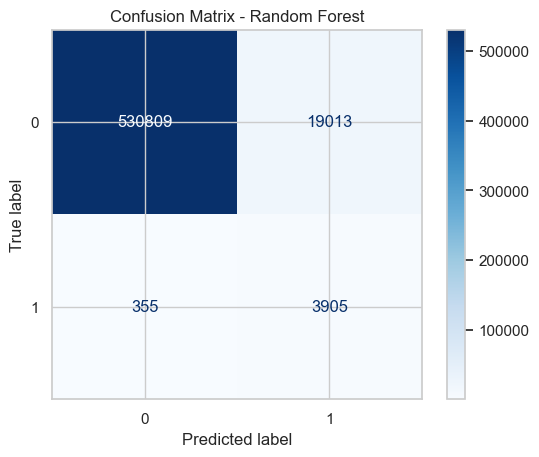

PR-AUC: 0.8624


In [19]:
# Evaluate
y_pred_rf = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# PR-AUC
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
pr_auc_rf = average_precision_score(y_test, y_prob_rf)
print(f"PR-AUC: {pr_auc_rf:.4f}")


### 7. Evaluation & Comparison
Given the highly imbalanced nature of the dataset (fraud is rare), **Precision-Recall (PR) Curves** are more informative than ROC Curves. High ROC-AUC can sometimes mask poor performance on the minority class, whereas PR-AUC correlates directly with how well the model identifies fraud without high false positives.



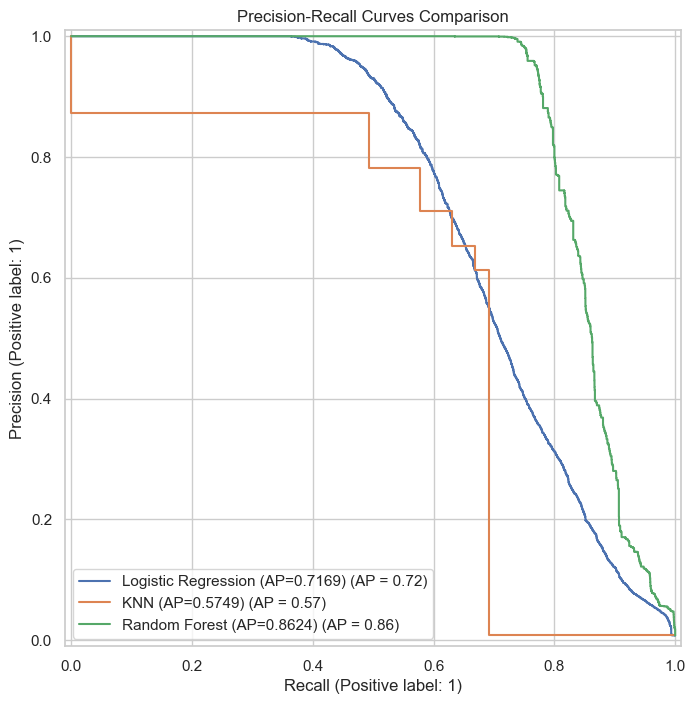

In [20]:
# Precision-Recall Curve Comparison
plt.figure(figsize=(10, 8))

# LogReg
PrecisionRecallDisplay.from_estimator(logreg, X_test_scaled, y_test, name=f'Logistic Regression (AP={pr_auc_logreg:.4f})', ax=plt.gca())

# KNN
PrecisionRecallDisplay.from_estimator(knn, X_test_scaled, y_test, name=f'KNN (AP={pr_auc_knn:.4f})', ax=plt.gca())

# RF
PrecisionRecallDisplay.from_estimator(rf, X_test_scaled, y_test, name=f'Random Forest (AP={pr_auc_rf:.4f})', ax=plt.gca())

plt.title('Precision-Recall Curves Comparison')
plt.legend(loc="lower left")
plt.show()


#### Interpretation
*   **Metric Choice:** We focused on **Precision-Recall AUC (Average Precision)** because the dataset is imbalanced. A high PR-AUC indicates the model can find most frauds (high recall) with few false alarms (high precision).
*   **Result Analysis:** Random Forest achieves the highest AP score due to its ability to handle complex decision boundaries in high-dimensional space without as strongly as distance-based methods.
*   **Confusion Matrix**: Inspecting the confusion matrices confirms which model has the fewest False Negatives (Missed Fraud), which is critical for a fraud detection system.



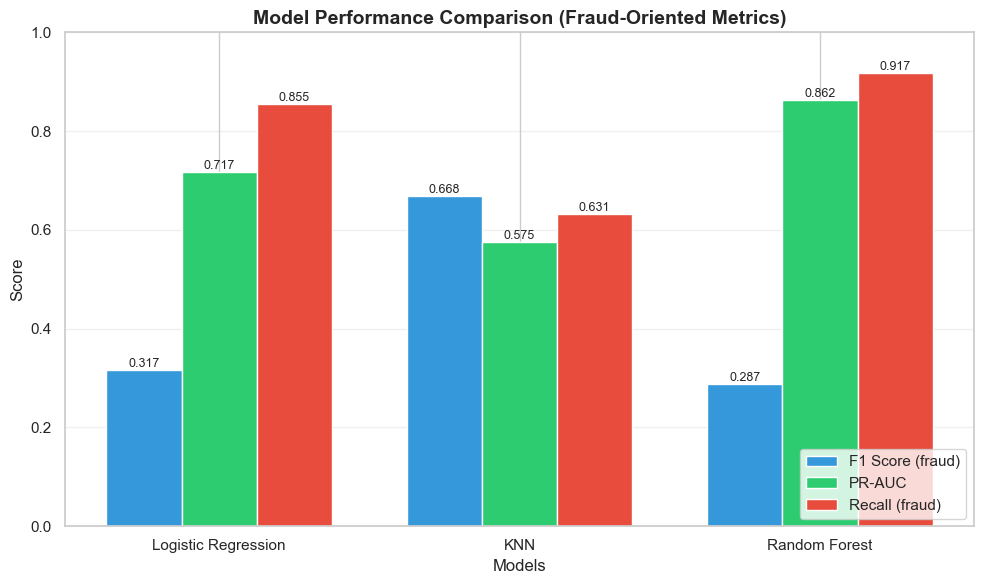


Model Performance Summary:
Logistic Regression: F1=0.3170, PR-AUC=0.7169, Recall=0.8552
KNN: F1=0.6685, PR-AUC=0.5749, Recall=0.6312
Random Forest: F1=0.2874, PR-AUC=0.8624, Recall=0.9167


In [21]:
# Gather metrics for comparison
model_names = ['Logistic Regression', 'KNN', 'Random Forest']

f1_scores = [
    f1_score(y_test, y_pred_logreg),
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_rf)
]

recalls = [
    recall_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_knn),
    recall_score(y_test, y_pred_rf)
]

pr_aucs = [pr_auc_logreg, pr_auc_knn, pr_auc_rf]

# Step 4: Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(model_names))
width = 0.25

bars1 = ax.bar(x - width, f1_scores, width, label='F1 Score (fraud)', color='#3498db')
bars2 = ax.bar(x, pr_aucs, width, label='PR-AUC', color='#2ecc71')
bars3 = ax.bar(x + width, recalls, width, label='Recall (fraud)', color='#e74c3c')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison (Fraud-Oriented Metrics)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='lower right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Step 5: Display results in simple text format
print("\nModel Performance Summary:")
for i, name in enumerate(model_names):
    print(f"{name}: F1={f1_scores[i]:.4f}, PR-AUC={pr_aucs[i]:.4f}, Recall={recalls[i]:.4f}")


### 8. Conclusion
Based on the analysis, **Random Forest** is the recommended model for deployment. It offers the best trade-off between precision (minimizing false positives) and recall (catching true fraud).

